In [1]:
import numpy as np
import torch
import torchvision
from typing import Tuple

In [2]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

# Load dataset

In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda

def load_mnist(train=True, shrinkage=None):
    dataset = torchvision.datasets.MNIST(
        root='.',
        download=True,
        train=train,
        transform=Compose([ToTensor(), Lambda(torch.flatten)])
    )
    if shrinkage:
        dataset_size = len(dataset)
        perm = torch.randperm(dataset_size)
        idx = perm[:int(dataset_size * shrinkage)]
        return torch.utils.data.Subset(dataset, idx)
    return dataset

train_dataset = load_mnist(train=True)
test_dataset = load_mnist(train=False)

# Model trainer

In [4]:
class ModelTrainer:
    def __init__(self, train_dataset, test_dataset, batch_size=128):
        self.batch_size = batch_size
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def train(self, model, optimizer, loss_fn=torch.nn.functional.cross_entropy, n_epochs=100, dfa=False):
        self.logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
        model = model.to(self.device)
        correct, numel = 0, 0
        for e in range(1, n_epochs + 1):
            if e%10==0:
              print(f'Epoch {e}')
            model.train()
            for x, y in self.train_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                output = model(x)
                y_pred = torch.argmax(output, dim=1)
                correct += torch.sum(y_pred == y).item()
                numel += self.batch_size
                loss = loss_fn(output, y)
                # zero out previous gradients and update weights
                optimizer.zero_grad()
                if dfa:
                    one_hot_target_output = torch.eye(output.shape[1])[y]
                    error = torch.nn.functional.softmax(output, dim=1) - one_hot_target_output
                    model.backward(error)
                loss.backward()
                optimizer.step()

            self.logs['train_loss'].append(loss.item())
            self.logs['train_accuracy'].append(correct / numel)
            correct, numel = 0, 0

            model.eval()
            with torch.no_grad():
                for x_test, y_test in self.test_loader:
                    x_test = x_test.to(self.device)
                    y_test = y_test.to(self.device)
                    output = model(x_test)
                    y_pred = torch.argmax(output, dim=1)
                    correct += torch.sum(y_pred == y_test).item()
                    numel += self.batch_size
                loss = loss_fn(output, y_test)

            self.logs['test_loss'].append(loss.item())
            self.logs['test_accuracy'].append(correct / numel)
            correct, numel = 0, 0

        return self.logs

batch_size = 64
trainer = ModelTrainer(train_dataset, test_dataset, batch_size=batch_size)

# Plot util

In [5]:
import matplotlib.pyplot as plt

def show_results(orientation='horizontal', accuracy_bottom=None, loss_top=None, **histories):
    if orientation == 'horizontal':
        f, ax = plt.subplots(1, 2, figsize=(16, 5))
    else:
        f, ax = plt.subplots(2, 1, figsize=(16, 16))
    for i, (name, h) in enumerate(histories.items()):
        if len(histories) == 1:
            ax[0].set_title("Best test accuracy: {:.2f}% (train: {:.2f}%)".format(
                max(h['test_accuracy']) * 100,
                max(h['train_accuracy']) * 100
            ))
        else:
            ax[0].set_title("Accuracy")
        ax[0].plot(h['train_accuracy'], color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[0].plot(h['test_accuracy'], color='C%s' % i, label='%s test' % name)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('accuracy')
        if accuracy_bottom:
            ax[0].set_ylim(bottom=accuracy_bottom)
        ax[0].legend()

        if len(histories) == 1:
            ax[1].set_title("Minimal train loss: {:.4f} (test: {:.4f})".format(
                min(h['train_loss']),
                min(h['test_loss'])
            ))
        else:
            ax[1].set_title("Loss")
        ax[1].plot(h['train_loss'], color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[1].plot(h['test_loss'], color='C%s' % i, label='%s test' % name)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('loss')
        if loss_top:
            ax[1].set_ylim(top=loss_top)
        ax[1].legend()

    plt.show()

# MNIST

# Back propagation

In [6]:
n_epochs = 150
learning_rate = 0.01

In [7]:
from torch import nn
# 7x240 Tanh
model1 = nn.Sequential(nn.Linear(784, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 10),
                            nn.Tanh())
# 1x800 Tanh
model2 = nn.Sequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            nn.Linear(800, 10),
                            nn.Tanh())
# 2x800 Tanh
model3 = nn.Sequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 10),
                            nn.Tanh())
# 3x800 Tanh
model4 = nn.Sequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 10),
                            nn.Tanh())
# 4x800 Tanh
model5 = nn.Sequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 10),
                            nn.Tanh())
# 2x800 Logistic
model6 = nn.Sequential(nn.Linear(784, 800),
                            nn.Sigmoid(),
                            nn.Linear(800, 800),
                            nn.Sigmoid(),
                            nn.Linear(800, 10),
                            nn.Sigmoid())

# 2x800 ReLU
model7 = nn.Sequential(nn.Linear(784, 800),
                            nn.ReLU(),
                            nn.Linear(800, 800),
                            nn.ReLU(),
                            nn.Linear(800, 10),
                            nn.ReLU())
# 2x800 Tanh + DO
model8 = nn.Sequential(nn.Dropout(0.1),
                            nn.Linear(784, 800),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            nn.Linear(800, 10),
                            nn.Dropout(0.5),
                            nn.Tanh())


In [8]:
models = [model1, model2, model3, model4, model5, model6, model7, model8]

Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch

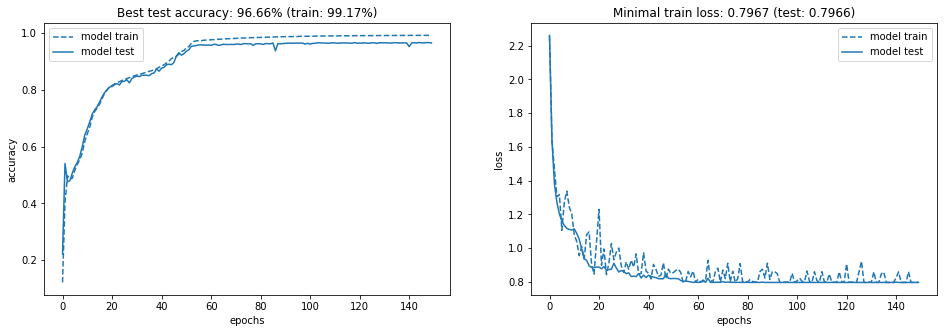

Results for model 1


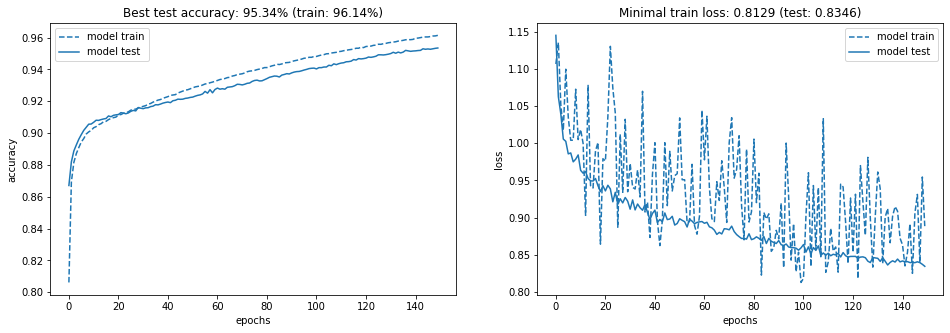

Results for model 2


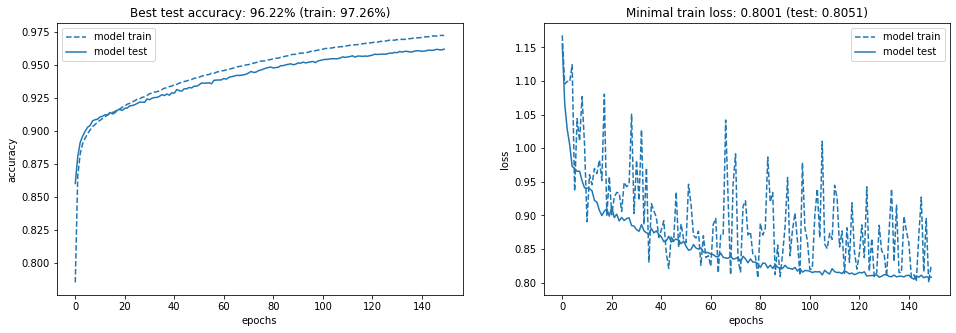

Results for model 3


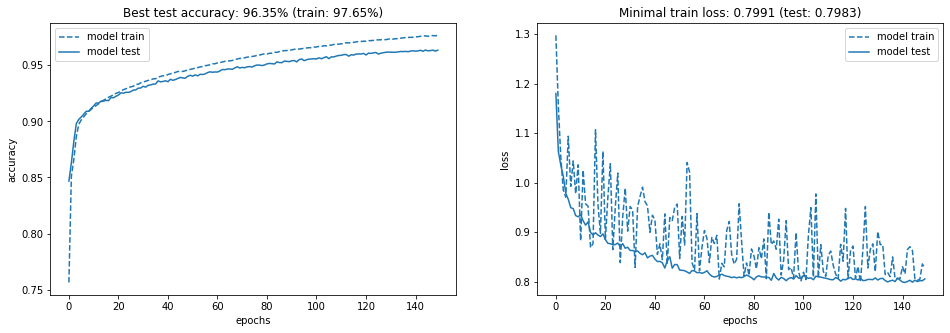

Results for model 4


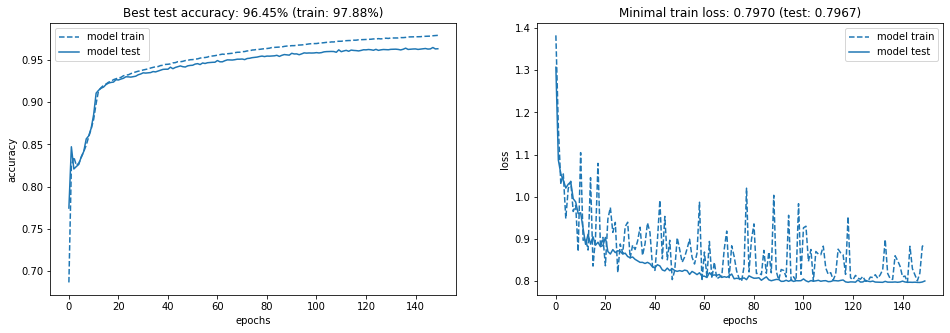

Results for model 5


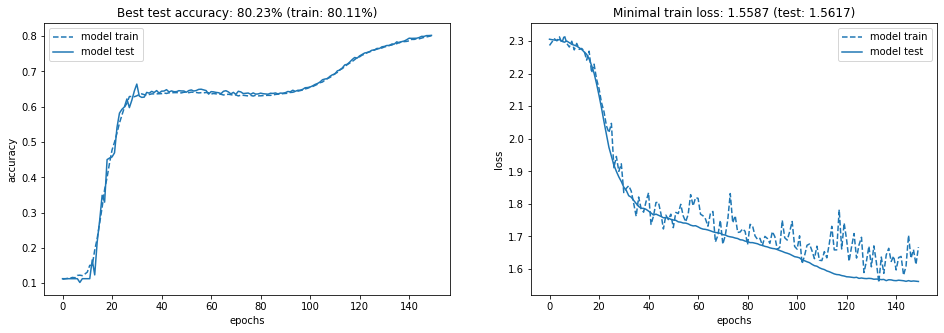

Results for model 6


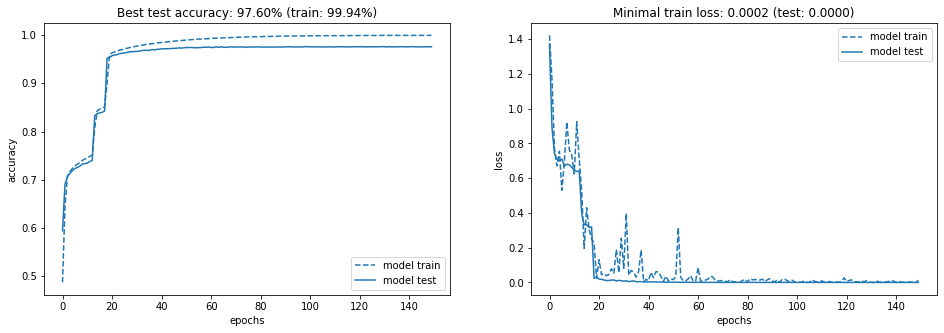

Results for model 7


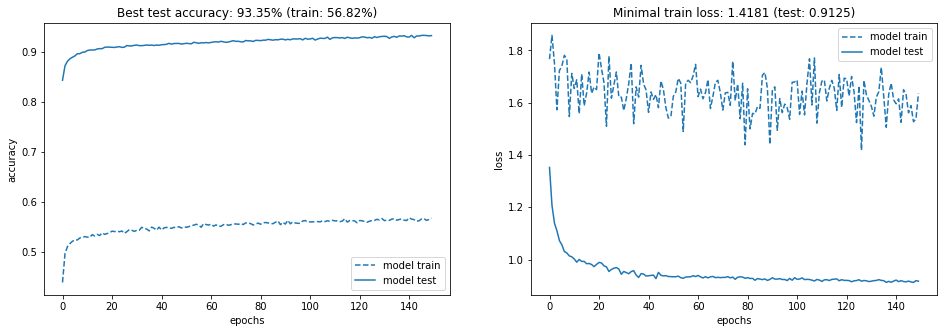

In [9]:
histories_bp_mnist = []
for i, model in enumerate(models): 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    history = trainer.train(model, optimizer, n_epochs=n_epochs)
    histories_bp_mnist.append(history)
for i, history in enumerate(histories_bp_mnist):
    print(f'Results for model {i}')
    show_results(model=history)

# DFA

In [10]:
# based on https://github.com/lightonai/principled-dfa-training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from collections import OrderedDict

class AsymmetricFeedback(nn.Module):
    """
    Detach local parts of the graph to prevent gradients from flowing.
    """
    def forward(self, input):
        output = input.detach() #Returns a new Tensor, detached from the current graph. The result will never require gradient.
        output.requires_grad = True
        return output

class AsymmetricSequential(nn.Sequential):
    def __init__(self, *args):
        super(AsymmetricSequential, self).__init__(*args)
        self.layers_units = OrderedDict()  # will store number of units for every layer
        self.random_matrix = None  # will store the biggest random matrix
        self.layers_input = OrderedDict()  # will store layers input to compute local gradients

    def build_feedback(self, input):
        """Generate  biggest random matrix"""
        layer_counter = 0
        for module in self._modules.values():
            if isinstance(module, AsymmetricFeedback):
                layer_counter += 1
                self.layers_units[f'layer{layer_counter}'] = np.prod(input.shape[1:])
            input = module(input)

        classes = np.prod(input.shape[1:])
        max_number_of_units = max(self.layers_units.values())
        self.random_matrix = torch.randn(classes, dim2)
        self.random_matrix = self.random_matrix.to(device)
    
    def forward(self, input):
        layer_counter = 0
        for module in self._modules.values():
            if isinstance(module, AsymmetricFeedback):
                layer_counter += 1
                self.layers_input[f'layer{layer_counter}'] = input
            input = module(input)
        return input

    def backward(self, error):
        error = error.to(device)
        random_gradient = error @ self.random_matrix
        for layer, input in self.layers_input.items():
            number_of_units = self.layers_units[layer]
            local_random_gradient = random_gradient[:input.shape[0], :number_of_units]
            local_random_gradient = local_random_gradient.view(*input.shape)
            local_random_gradient = local_random_gradient.to(device)
            input.backward(local_random_gradient)

In [11]:
n_epochs = 150
learning_rate = 0.01
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
input_sample, _ = next(iter(train_loader))

In [12]:
# 7x240 Tanh
model1 = AsymmetricSequential(nn.Linear(784, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(), 
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(), 
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(), 
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(), 
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(240, 10),
                            nn.Tanh())
# 1x800 Tanh
model2 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10),
                            nn.Tanh())
# 2x800 Tanh
model3 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10),
                            nn.Tanh())
# 3x800 Tanh
model4 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10),
                            nn.Tanh())
# 4x800 Tanh
model5 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10),
                            nn.Tanh())
# 2x800 Logistic
model6 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.Sigmoid(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Sigmoid(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10),
                            nn.Sigmoid())
# 2x800 ReLU
model7 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.ReLU(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.ReLU(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10),
                            nn.ReLU())
# 2x800 Tanh + DO
model8 = AsymmetricSequential(nn.Dropout(0.1),
                            nn.Linear(784, 800),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10),
                            nn.Dropout(0.5),
                            nn.Tanh())
models = [model1, model2, model3, model4, model5, model6, model7, model8]

Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoc

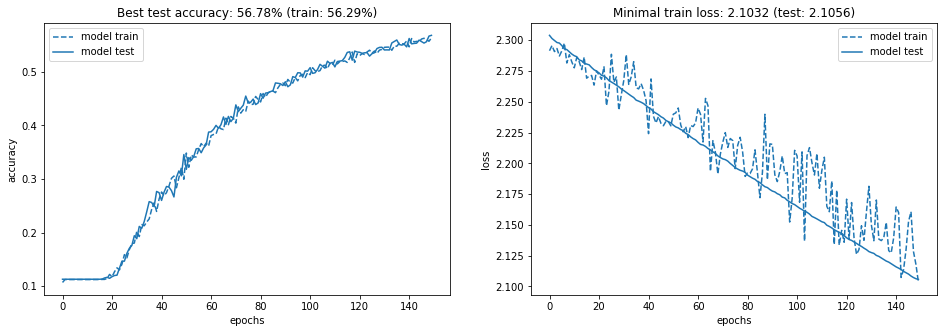

Results for model 1


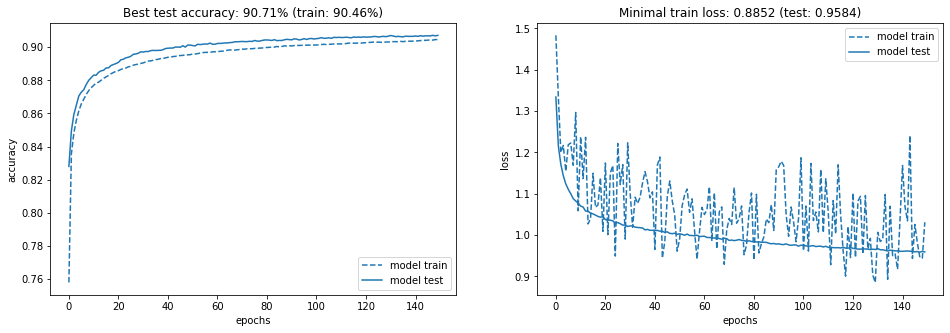

Results for model 2


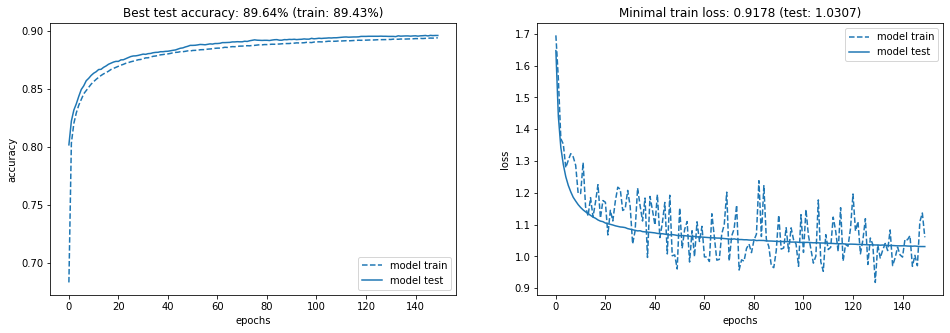

Results for model 3


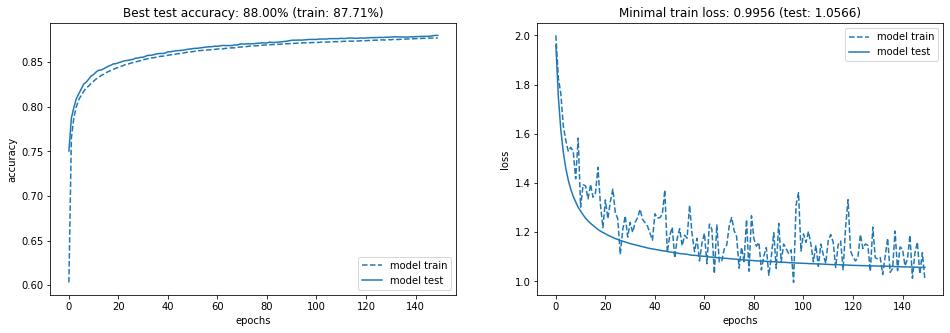

Results for model 4


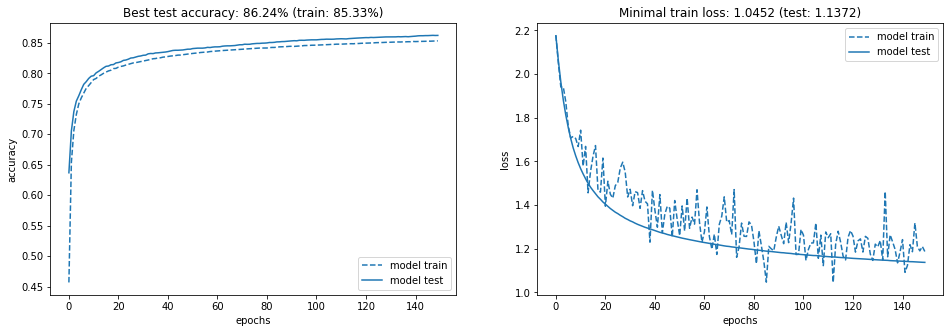

Results for model 5


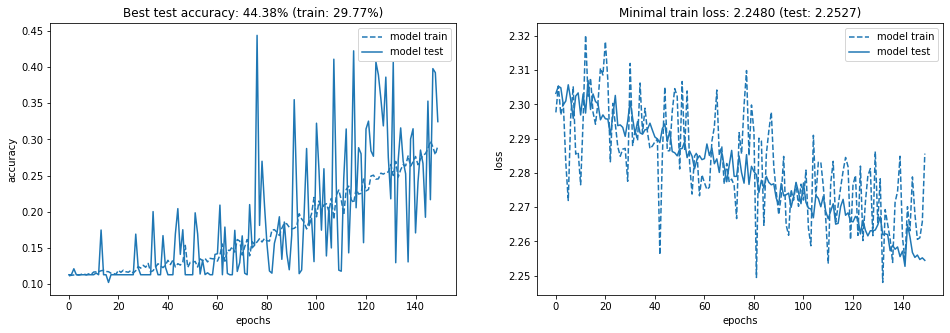

Results for model 6


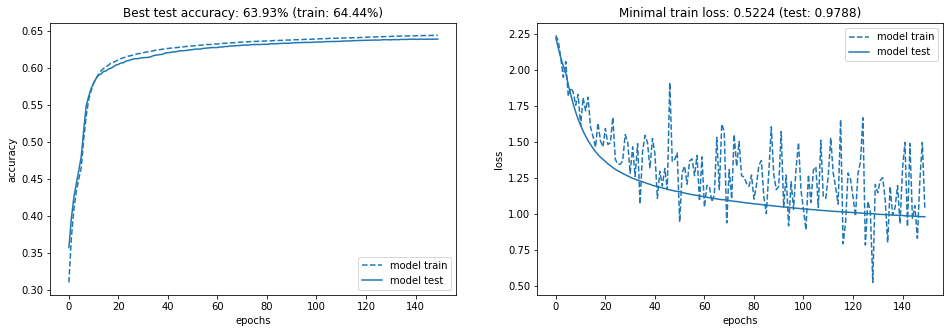

Results for model 7


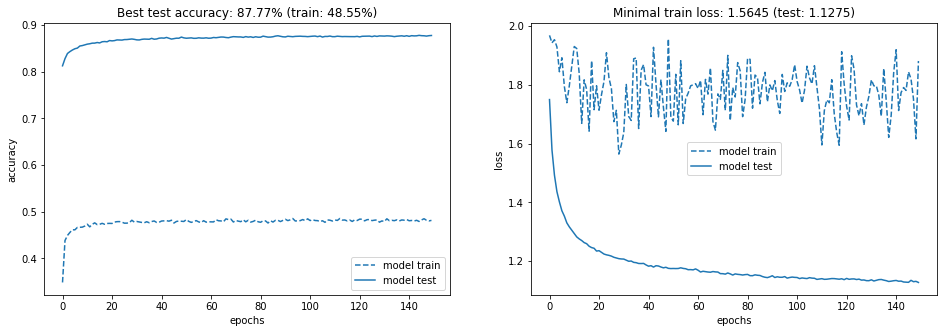

In [13]:
histories_dfa_mnist = []
for i, model in enumerate(models): 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    history = trainer.train(model, optimizer, n_epochs=n_epochs)
    histories_dfa_mnist.append(history)
for i, history in enumerate(histories_dfa_mnist):
    print(f'Results for model {i}')
    show_results(model=history)

# CIFAR-10

In [14]:
def load_cifar10(train=True, shrinkage=None):
    dataset = torchvision.datasets.CIFAR10(
        root='.',
        download=True,
        train=train,
        transform=Compose([ToTensor(), Lambda(torch.flatten)])
    )
    if shrinkage:
        dataset_size = len(dataset)
        perm = torch.randperm(dataset_size)
        idx = perm[:int(dataset_size * shrinkage)]
        return torch.utils.data.Subset(dataset, idx)
    return dataset

train_dataset = load_cifar10(train=True)
test_dataset = load_cifar10(train=False)


Files already downloaded and verified
Files already downloaded and verified


In [15]:
batch_size = 64
trainer = ModelTrainer(train_dataset, test_dataset, batch_size=batch_size)
n_epochs = 150
learning_rate = 0.01
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
input_sample, _ = next(iter(train_loader))

# CIFAR-10 BP

In [16]:
# 1x1000 Tanh
model1 = nn.Sequential(nn.Linear(3072, 1000),
                            nn.Tanh(),
                            nn.Linear(1000, 10),
                            nn.Tanh())
# 3x1000 Tanh
model2 = nn.Sequential(nn.Linear(3072, 1000),
                            nn.Tanh(),
                            nn.Linear(1000, 1000),
                            nn.Tanh(),
                            nn.Linear(1000, 1000),
                            nn.Tanh(),
                            nn.Linear(1000, 10),
                            nn.Tanh())
# 3x1000 Tanh + DO
model3 = nn.Sequential(nn.Dropout(0.1),
                            nn.Linear(3072, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            nn.Linear(1000, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            nn.Linear(1000, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            nn.Linear(1000, 10),
                            nn.Dropout(0.5),
                            nn.Tanh())
models = [model1, model2, model3]

Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Results for model 0


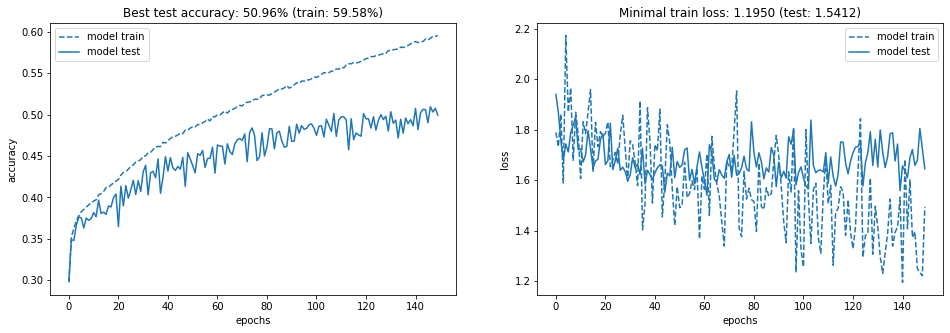

Results for model 1


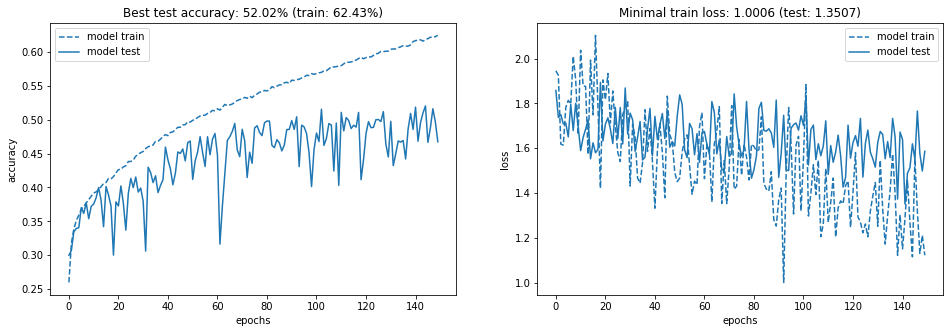

Results for model 2


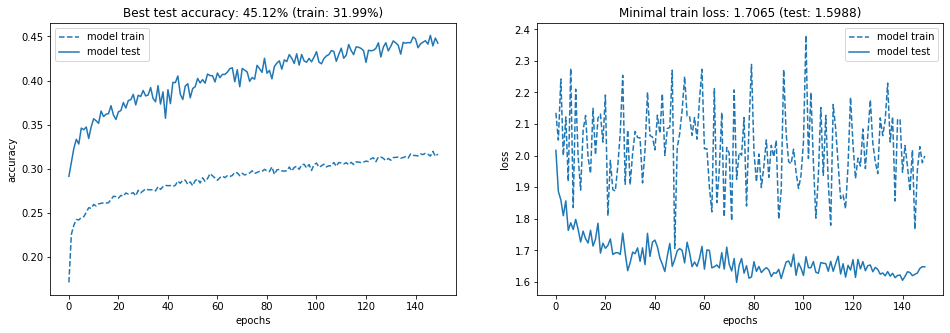

In [17]:
histories_bp_cifar = []
for i, model in enumerate(models): 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    history = trainer.train(model, optimizer, n_epochs=n_epochs)
    histories_bp_cifar.append(history)
for i, history in enumerate(histories_bp_cifar):
    print(f'Results for model {i}')
    show_results(model=history)

# CIFAR-10 DFA

In [18]:
# 1x1000 Tanh
model1 = AsymmetricSequential(nn.Linear(3072, 1000),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 10),
                            nn.Tanh())
# 3x1000 Tanh
model2 = AsymmetricSequential(nn.Linear(3072, 1000),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 1000),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 1000),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 10),
                            nn.Tanh())
# 3x1000 Tanh + DO
model3 = AsymmetricSequential(nn.Dropout(0.1),
                            nn.Linear(3072, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 10),
                            nn.Dropout(0.5),
                            nn.Tanh())
models = [model1, model2, model3]

Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Results for model 0


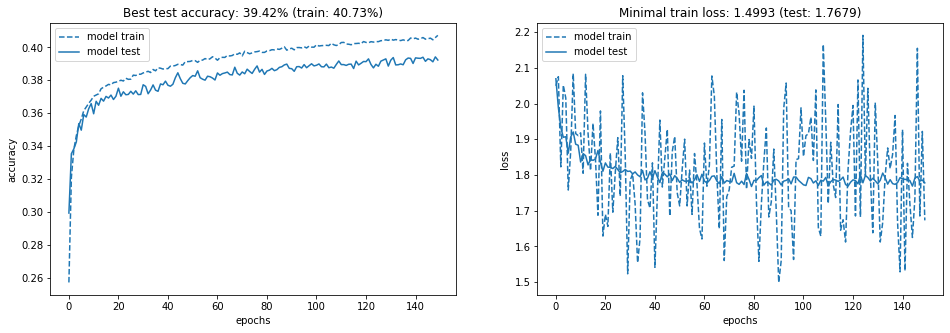

Results for model 1


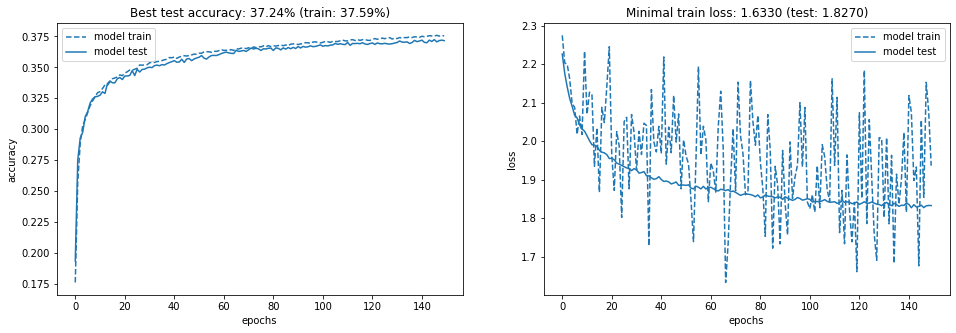

Results for model 2


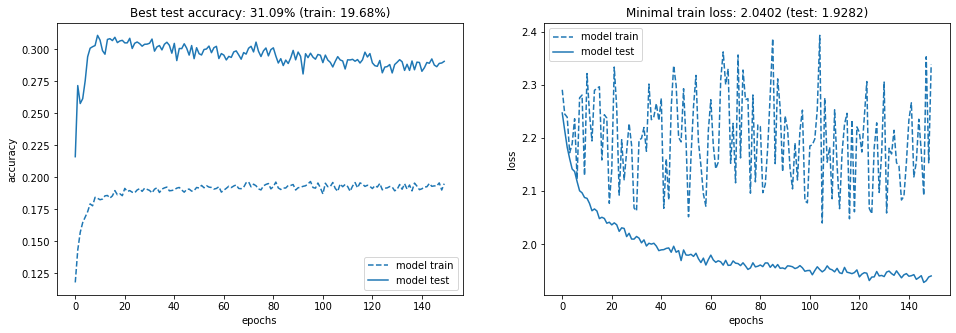

In [19]:
histories_dfa_cifar = []
for i, model in enumerate(models): 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    history = trainer.train(model, optimizer, n_epochs=n_epochs)
    histories_dfa_cifar.append(history)
for i, history in enumerate(histories_dfa_cifar):
    print(f'Results for model {i}')
    show_results(model=history)